## Logistic Regression

In [ ]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('titanic_disaster.csv')
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
df.nunique()

,0
PassengerId,891
Survived,2
Pclass,3
Name,891
Sex,2
Age,88
SibSp,7
Parch,7
Ticket,681
Fare,248


In [ ]:
df['Survived'].value_counts()

,count
Survived,
0,549
1,342


In [ ]:
irre_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df_cleaned = df.drop(irre_cols, axis=1)

df_cleaned

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [ ]:
# Feature engineering for SibSp and Parch

df_cleaned['FamilySize'] = df_cleaned['SibSp'] + df_cleaned['Parch'] + 1
df_cleaned['IsAlone'] = (df_cleaned['FamilySize'] == 1).astype(int)

In [ ]:
df_cleaned = df_cleaned.drop(columns=['SibSp','Parch','Embarked'])
df_cleaned

,Survived,Pclass,Sex,Age,Fare,FamilySize,IsAlone
0,0,3,male,22.0,7.2500,2,0
1,1,1,female,38.0,71.2833,2,0
2,1,3,female,26.0,7.9250,1,1
3,1,1,female,35.0,53.1000,2,0
4,0,3,male,35.0,8.0500,1,1
...,...,...,...,...,...,...,...
886,0,2,male,27.0,13.0000,1,1
887,1,1,female,19.0,30.0000,1,1
888,0,3,female,NaN,23.4500,4,0
889,1,1,male,26.0,30.0000,1,1


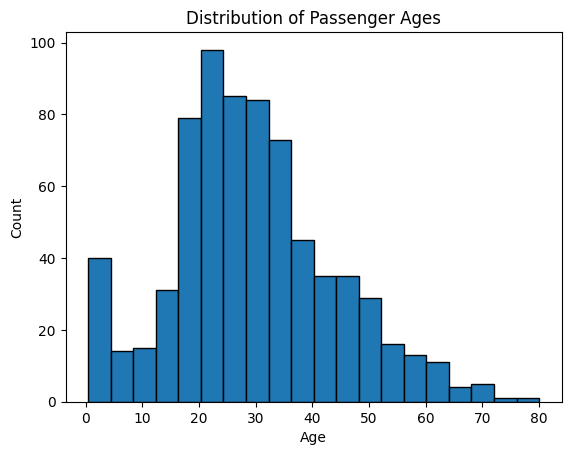

In [ ]:
# Checking for missing values
df_cleaned.isnull().sum()

# Checking the distribution of Age after removing NaN
age_data = df_cleaned['Age'].dropna()

# Plot histogram
plt.hist(age_data, bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Passenger Ages')
plt.show()

# It is right skewed so I'm gonna input the median

In [ ]:
# Imputing Missing Value for Age (Mean, Median, Most frequent)
numeric_col = ['Age']

imputer = SimpleImputer(strategy = 'median')
df_cleaned[numeric_col] = imputer.fit_transform(df_cleaned[numeric_col])

In [ ]:
df['Fare'] = np.log1p(df['Fare'])

In [ ]:
# Imputing missing value for Embark (Mode/ Most frequent)
# cat_col = ['Embarked']

# imputer_cat = SimpleImputer(strategy = 'most_frequent')
# df_cleaned[cat_col] = imputer_cat.fit_transform(df_cleaned[cat_col])

In [ ]:
# Transforming categorical variables into dummy variables
# For logistic regression, it is suggested to convert Pclass to dummy, for decision trees is not needed (scale invariant)

df_cleaned = pd.get_dummies(df_cleaned, columns=['Pclass', 'Sex'], drop_first=True, dtype=int)


In [ ]:
df_cleaned

,Survived,Age,Fare,FamilySize,IsAlone,Pclass_2,Pclass_3,Sex_male
0,0,22.0,7.2500,2,0,0,1,1
1,1,38.0,71.2833,2,0,0,0,0
2,1,26.0,7.9250,1,1,0,1,0
3,1,35.0,53.1000,2,0,0,0,0
4,0,35.0,8.0500,1,1,0,1,1
...,...,...,...,...,...,...,...,...
886,0,27.0,13.0000,1,1,1,0,1
887,1,19.0,30.0000,1,1,0,0,0
888,0,28.0,23.4500,4,0,0,1,0
889,1,26.0,30.0000,1,1,0,0,1


In [ ]:
# Checking for multicollinearity or correlation
predictors = ['Age','Fare','FamilySize','IsAlone','Pclass_2','Pclass_3','Sex_male']
corr = df_cleaned[predictors].corr()
print(corr)

                 Age      Fare  FamilySize   IsAlone  Pclass_2  Pclass_3  \
Age         1.000000  0.096688   -0.245619  0.171647  0.015831 -0.291955   
Fare        0.096688  1.000000    0.217138 -0.271832 -0.118557 -0.413333   
FamilySize -0.245619  0.217138    1.000000 -0.690922 -0.038594  0.071142   
IsAlone     0.171647 -0.271832   -0.690922  1.000000 -0.039070  0.129472   
Pclass_2    0.015831 -0.118557   -0.038594 -0.039070  1.000000 -0.565210   
Pclass_3   -0.291955 -0.413333    0.071142  0.129472 -0.565210  1.000000   
Sex_male    0.081163 -0.182333   -0.200988  0.303646 -0.064746  0.137143   

            Sex_male  
Age         0.081163  
Fare       -0.182333  
FamilySize -0.200988  
IsAlone     0.303646  
Pclass_2   -0.064746  
Pclass_3    0.137143  
Sex_male    1.000000  


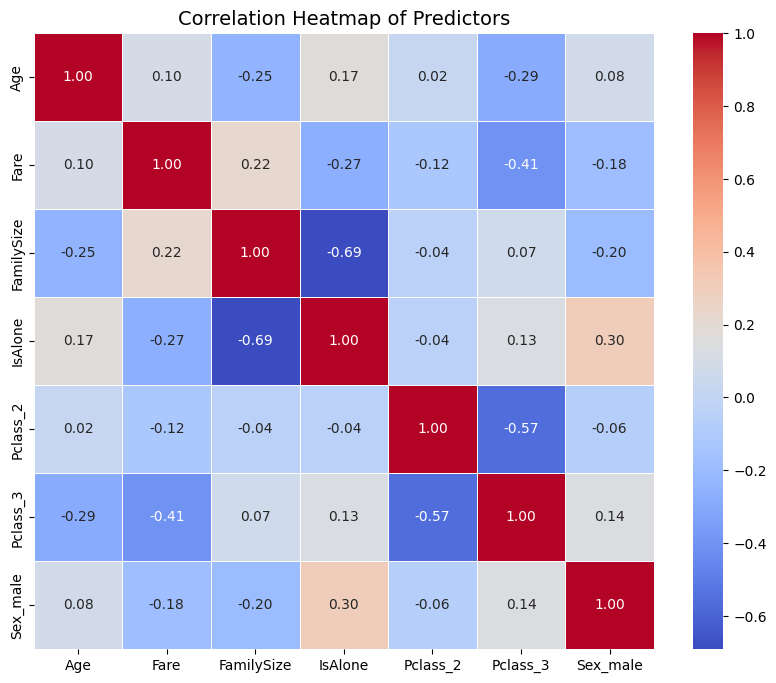

In [ ]:
# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Predictors", fontsize=14)
plt.show()

In [ ]:
# Splitting the dataset, I removed IsAlone here because there is -0.69 correlation.
# Removing this feature decreased a bit of accuracy
predictors = ['Age','Fare','FamilySize','Pclass_2','Pclass_3','Sex_male','IsAlone']

X = df_cleaned[predictors]
y = df_cleaned['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y , train_size = 0.75, random_state=42)


In [ ]:
# Scaling X

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
# Fitting Logistic Regression to the model

lr = LogisticRegression(random_state=42)
lr.fit(X_train_scaled, y_train)

# Getting the log odds of logistic
y_proba = lr.predict_proba(X_test_scaled)[:,1]

# Customizing threshold

threshold = 0.55
y_pred_thresh = (y_proba >= threshold).astype(int)

# Predict
#y_pred = lr.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_thresh)
print('Accuracy:', accuracy)

cm = confusion_matrix(y_test, y_pred_thresh)
print('Confusion Matrix:', cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_thresh))

Accuracy: 0.8071748878923767
Confusion Matrix: [[120  14]
 [ 29  60]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       134
           1       0.81      0.67      0.74        89

    accuracy                           0.81       223
   macro avg       0.81      0.78      0.79       223
weighted avg       0.81      0.81      0.80       223



In [ ]:
# Checking Coefficients and intercept
feature_names = X.columns

coef_table = pd.DataFrame({'Feature': feature_names, 'Coefficient': lr.coef_[0]})

coef_table_sorted = coef_table.sort_values(by='Coefficient',ascending=False)
print(coef_table_sorted)

      Feature  Coefficient
1        Fare     0.250002
3    Pclass_2    -0.196276
6     IsAlone    -0.329314
0         Age    -0.406200
2  FamilySize    -0.651663
4    Pclass_3    -0.814388
5    Sex_male    -1.248326


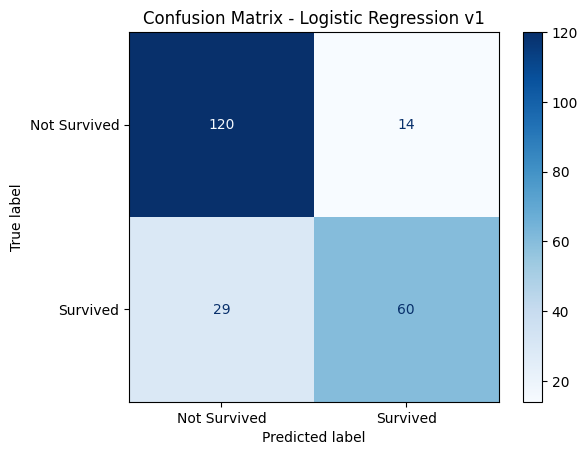

In [ ]:
# Confusion Matrix Display

disp = ConfusionMatrixDisplay(cm, display_labels=['Not Survived','Survived'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression v1')
plt.show()

# In this case we want to minimize False Positives (Predicting to be a survivor then dying is more painful)

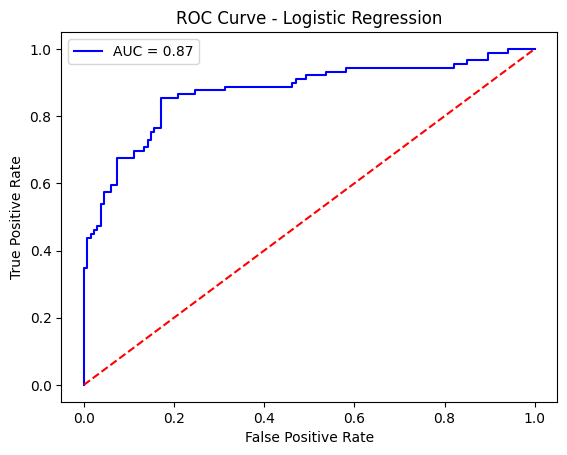

In [ ]:
# Improving the performance of logistic regression

y_proba = lr.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

auc_score = roc_auc_score(y_test, y_proba)

# Plot ROC Curve
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()



In [ ]:
# Finding the best threshold (0.55 or 0.6)

thresholds = [0.5, 0.55, 0.6, 0.65, 0.70]

accuracies = []

for i in thresholds:
  y_pred_thresh = (y_proba >= i).astype(int)
  acc = accuracy_score(y_test, y_pred_thresh)
  print('Accuracy at a threshold',{i}, acc)

Accuracy at a threshold {0.5} 0.8116591928251121
Accuracy at a threshold {0.55} 0.8071748878923767
Accuracy at a threshold {0.6} 0.7982062780269058
Accuracy at a threshold {0.65} 0.7982062780269058
Accuracy at a threshold {0.7} 0.7937219730941704


In [ ]:
# Define the model
lr = LogisticRegression(max_iter=1000, random_state=42)

# Define range of C values to test
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Use GridSearchCV to find the best one
grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print("Best C:", grid.best_params_['C'])
print("Best cross-validated accuracy:", grid.best_score_)


Best C: 10
Best cross-validated accuracy: 0.8053529345752442


In [ ]:
# Predicting on a new unseen data using GridSearchCV Model

new_data = {
    'Age': [28],
    'Fare': [72.5],
    'FamilySize': [3],
    'Pclass_2': [0],
    'Pclass_3': [1],
    'Sex_male': [1],
    'IsAlone': [1]
}
df_new = pd.DataFrame(new_data)

best_lr = grid.best_estimator_

X_new_scaled = scaler.transform(df_new)
y_pred_new = best_lr.predict(X_new_scaled)
print('predicted_class:', y_pred_new[0])

# Checking the log odds
y_proba_new = best_lr.predict_proba(X_new_scaled)[:,1]
print('predicted_proba:', y_proba_new)

predicted_class: 0
predicted_proba: [0.04980366]


In [ ]:
# Check coefficients and intercept
print("Coeficient:", grid.best_estimator_.coef_)
print('Intercept:',grid.best_estimator_.intercept_)

Coeficient: [[-0.41945483  0.24544653 -0.67899474 -0.21030746 -0.83811322 -1.26568337
  -0.34328888]]
Intercept: [-0.67204318]


### LogisticRegressionCV

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
log_l1 = LogisticRegressionCV(cv = 5, penalty='l1', solver='saga', max_iter = 10000, random_state=42, class_weight='balanced')

log_l1.fit(X_train_scaled, y_train)
print('Best C:', log_l1.C_[0])

y_logCV_pred = log_l1.predict(X_test_scaled)

train_acc = log_l1.score(X_train_scaled, y_train)
test_acc = log_l1.score(X_test_scaled, y_test)

print('train_acc:', train_acc)
print('test_acc:', test_acc)


Best C: 0.046415888336127774
train_acc: 0.7889221556886228
test_acc: 0.7757847533632287


# KNN - Tuned

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
classifier = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(1, 9, 2),
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}

grid_KNN = GridSearchCV(estimator = classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs = -1, verbose=0)
grid_KNN.fit(X_train_scaled, y_train)

print('Best Params:', grid_KNN.best_params_)
print('Best CV accuracy:', grid_KNN.best_score_)


Best Params: {'n_neighbors': np.int64(5), 'p': 1, 'weights': 'uniform'}
Best CV accuracy: 0.8174054539333409


In [ ]:
best_KNN = grid_KNN.best_estimator_

# Predicting on test
y_pred_KNN = best_KNN.predict(X_test_scaled)
accuracy_KNN = accuracy_score(y_test, y_pred_KNN)

print('accuracy_KNN:', accuracy_KNN)

accuracy_KNN: 0.726457399103139


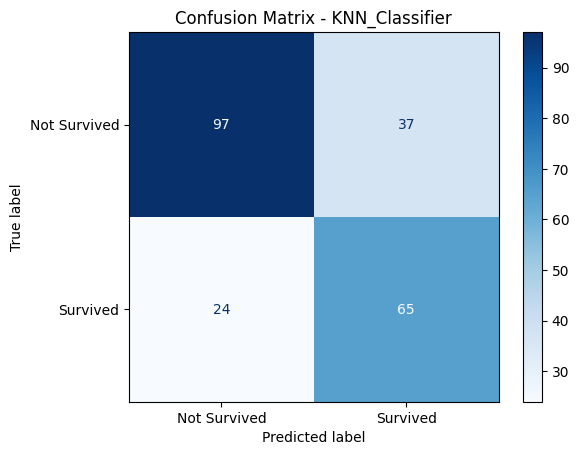

In [ ]:
# Visualizing the confusion matrix
# Confusion Matrix Display

cm = confusion_matrix(y_test, y_pred_KNN)
disp = ConfusionMatrixDisplay(cm, display_labels=['Not Survived','Survived'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - KNN_Classifier')
plt.show()

In [ ]:
# New prediction

# Decision Tree - Tuned

> Add blockquote



In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# DT with entropy as parameter
dt_classifier = DecisionTreeClassifier(random_state=42)

In [ ]:
# This one suggests overfitting
# WITHOUT TUNING HYPERPARAMETERS, THERE'S OVERFITTING
# dt_classifier.fit(X_train, y_train)

# dt_y_train = dt_classifier.predict(X_train)
# dt_y_pred = dt_classifier.predict(X_test)

# acc_train = accuracy_score(y_train, dt_y_train)
# acc_test = accuracy_score(y_test, dt_y_pred)

# print('Train Accuracy:', acc_train)
# print('Test Accuracy:', acc_test)

In [ ]:
# Finding the best hyperparameters using GridSearchCV
param_grid = {'criterion': ['entropy', 'gini'],
               'max_depth': [3, 4, 5, 6, None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 5]}

grid_DT = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_DT.fit(X_train, y_train)

print('Best Parameters:', grid_DT.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [ ]:
best_DT = grid_DT.best_estimator_

y_grid_train = best_DT.predict(X_train)
y_grid_pred = best_DT.predict(X_test)

acc_train = accuracy_score(y_train, y_grid_train)
acc_test = accuracy_score(y_test, y_grid_pred)

print('Train Accuracy:', acc_train)
print('Test Accuracy:', acc_test)

Train Accuracy: 0.8323353293413174
Test Accuracy: 0.8071748878923767


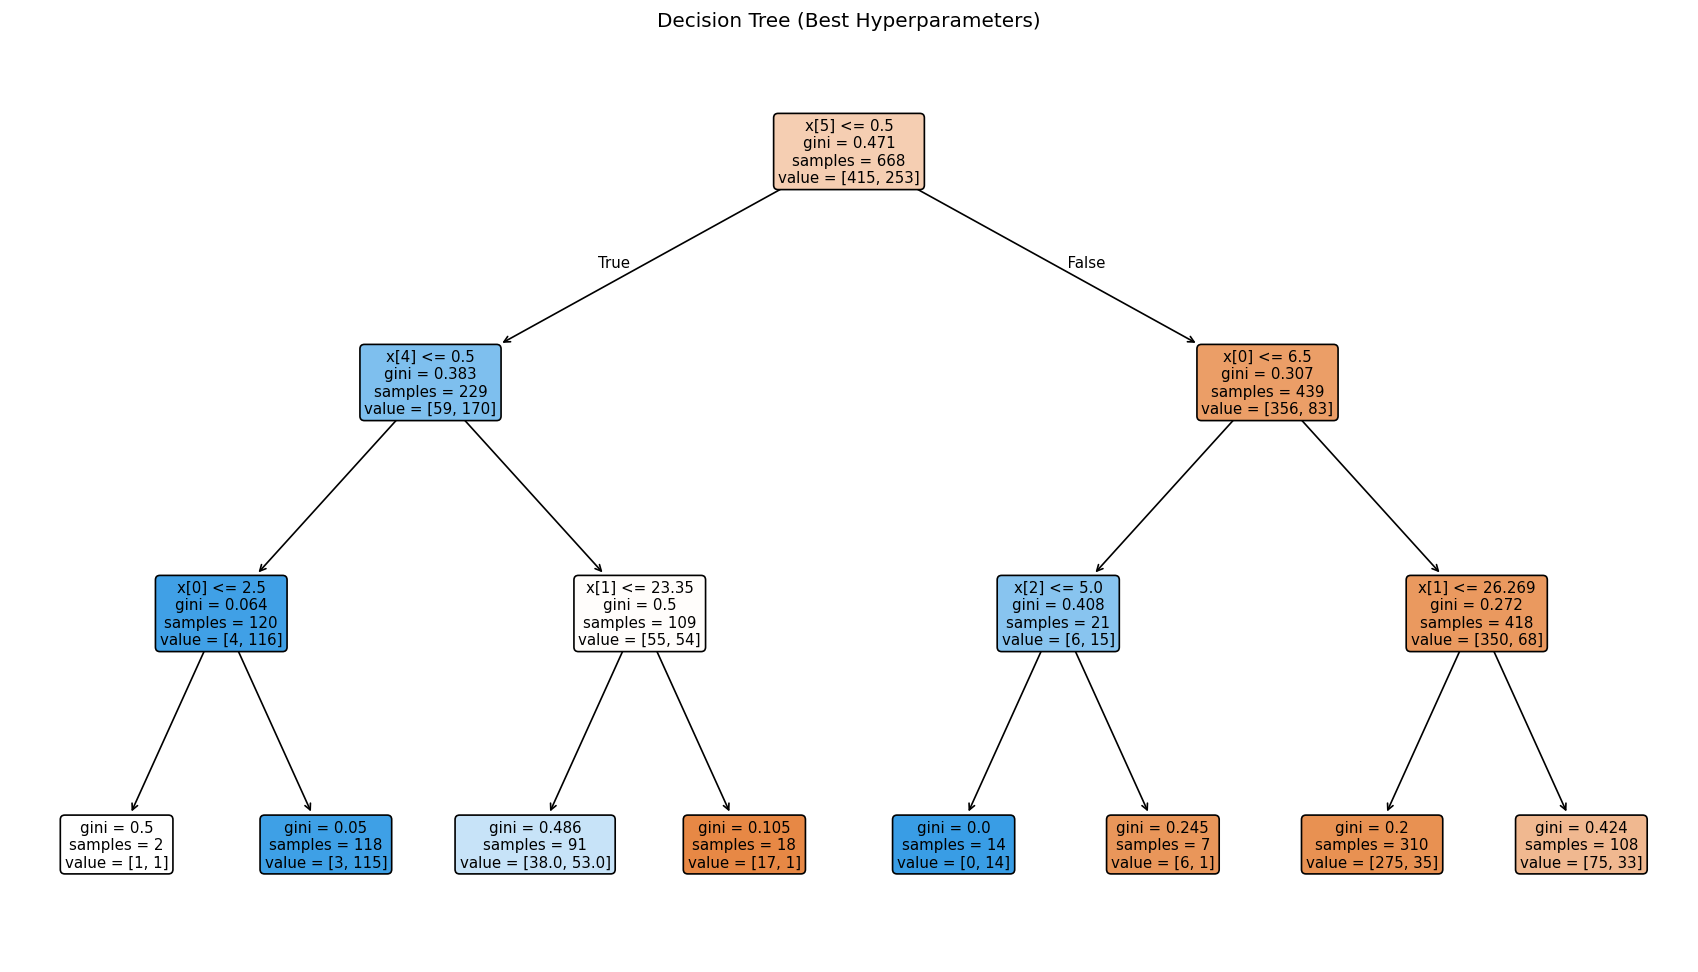

In [ ]:
# Plotting the Single Tree

from sklearn.tree import plot_tree

best_tree = grid_DT.best_estimator_

plt.figure(figsize=(18, 10), dpi=120)
plot_tree(
    best_tree,
    filled=True,
    rounded=True,
    fontsize=9,
    max_depth=None  # try 3–4 if the tree is too big to read
)
plt.title("Decision Tree (Best Hyperparameters)")
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=42)
#rf.fit(X_train, y_train)

In [ ]:
# Cross-validation to tune random forest parameters

param_grid = {'n_estimators': [100, 200, 300, 500], 'max_depth': [3, 5, 8, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(rf, param_grid, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print('Best Parameters:', grid_rf.best_params_)
print('Best CV Accuracy:', grid_rf.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best CV Accuracy: 0.8473571989675681


In [ ]:
# So I can use the same grid model (as a substitute of Random Forest) to predict?

best_rf = grid_rf.best_estimator_

y_grid_train = best_rf.predict(X_train)
y_grid_pred = best_rf.predict(X_test)

acc_train = accuracy_score(y_train, y_grid_train)
acc_test = accuracy_score(y_test, y_grid_pred)

print('Training Accuracy:',acc_train)
print('Testing Accuracy:', acc_test)

Training Accuracy: 0.907185628742515
Testing Accuracy: 0.8116591928251121


In [ ]:
best_rf

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, random_state=42)

In [ ]:
# Visualize performance on training and testing data
# WITHOUT TUNING HYPERPARAMETERS, THERE'S OVERFITTING

# y_train_pred = rf.predict(X_train)
# y_test_pred = rf.predict(X_test)

# train_acc = accuracy_score(y_train, y_train_pred)
# test_acc = accuracy_score(y_test, y_test_pred)

# print('Training accuracy:', train_acc)
# print('Testing accuracy:', test_acc)

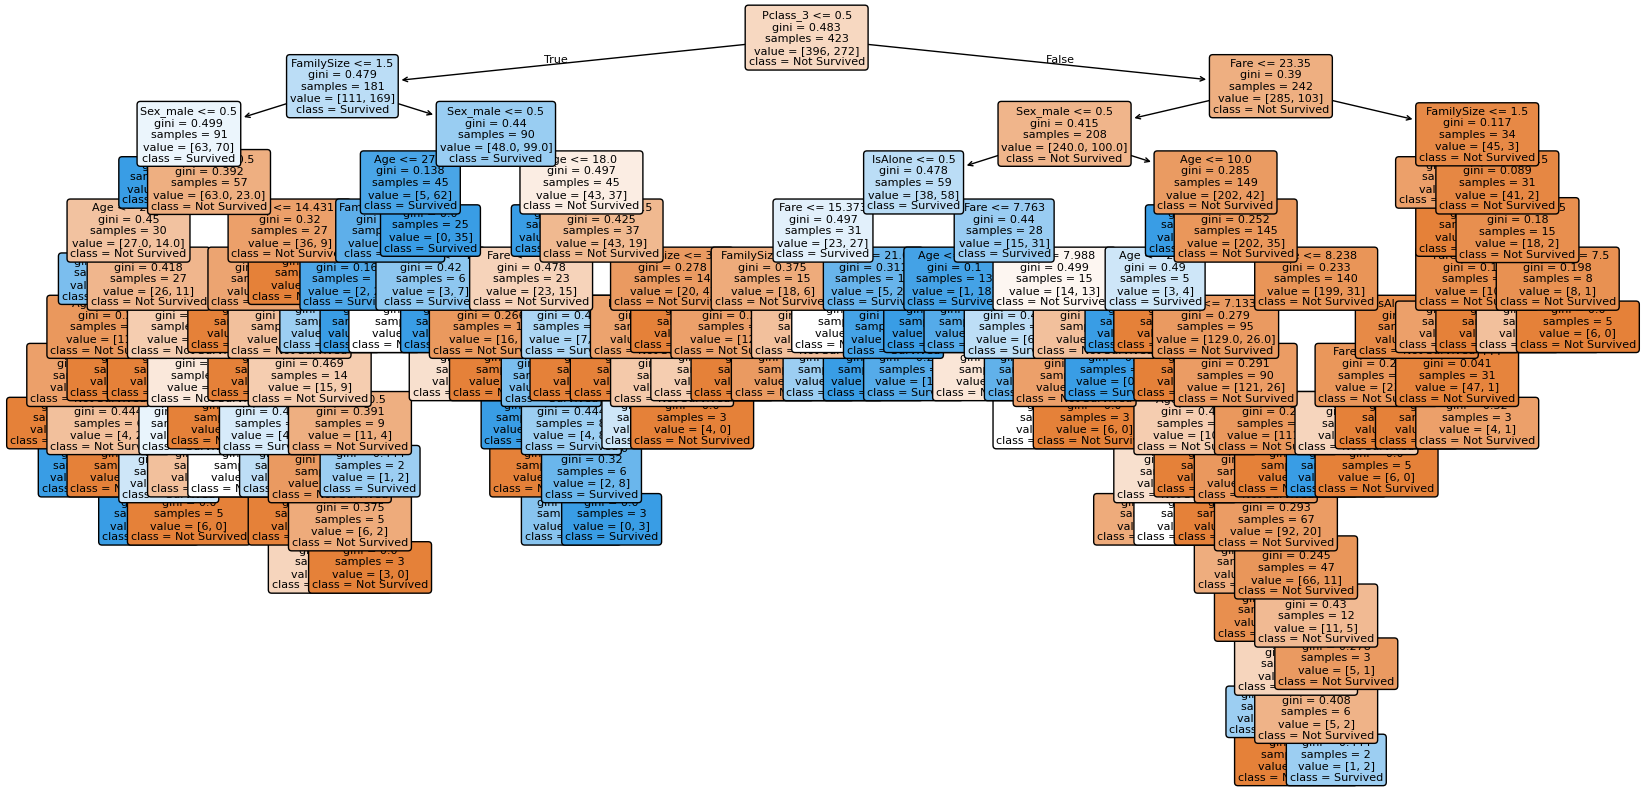

In [ ]:
one_tree = best_rf.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(one_tree,
          feature_names=X.columns,
          class_names=['Not Survived', 'Survived'],
          filled=True,
          rounded=True,
          fontsize=8)
plt.show()

In [ ]:
# Predicting on new data

# Suppose these are your training columns:
train_cols = X_train.columns  # keep this after training

# For a new row:
df_new_raw = pd.DataFrame({
    "Age":[28], "Fare":[72.5], "FamilySize":[3], "IsAlone": [1],
    "Pclass":[3], "Sex":["male"], "Embarked":["S"]
})

df_new_raw.drop(columns=['Embarked'])

X_new = pd.get_dummies(df_new_raw, columns=['Pclass','Sex'], drop_first=False, dtype=int)
X_new

# Reindex to ensure same structure as training data
X_new = X_new.reindex(columns=train_cols,fill_value=0)

# New Predictions
y_new_pred = grid_rf.predict(X_new)
y_new_proba = grid_rf.predict_proba(X_new)[:,1]

print('Predicted Class:', y_new_pred[0])
print('Predicted Probability:', y_new_proba[0])


Predicted Class: 0
Predicted Probability: 0.3909215803003242


# SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_clf = SVC(C=1, kernel = 'linear', gamma = 'scale', random_state=42, probability=True)

svm_clf.fit(X_train_scaled, y_train)

train_pred = svm_clf.predict(X_train_scaled)
y_pred = svm_clf.predict(X_test_scaled)

acc_train = accuracy_score(y_train, train_pred)
acc_test = accuracy_score(y_test, y_pred)

print('Training accuracy:', acc_train)
print('Test Accuracy:', acc_test)


Training accuracy: 0.7979041916167665
Test Accuracy: 0.8116591928251121


# XG Boost - Not used in this case due to simplicity of the model.
# XG is suitable for complex dataset (thousand features, missing values, nonlinear relationships)

In [ ]:
# from xgboost import XGBClassifier

In [ ]:
# xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# xgb.fit(X_train, y_train)

# train_pred = xgb.predict(X_train)
# y_pred = xgb.predict(X_test)

# acc_train = accuracy_score(y_train, train_pred)
# acc_test = accuracy_score(y_test, y_pred)

# print('Training accuracy:', acc_train)
# print('Test Accuracy:', acc_test)

# Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train_scaled, y_train)

train_pred = gnb.predict(X_train_scaled)
y_pred = gnb.predict(X_test_scaled)

acc_train = accuracy_score(y_train, train_pred)
acc_test = accuracy_score(y_test, y_pred)

print('Training accuracy:', acc_train)
print('Test Accuracy:', acc_test)

Training accuracy: 0.7964071856287425
Test Accuracy: 0.7713004484304933


# ENSEMBLE

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
print(type(gnb))
print(type(best_DT))
print(type(best_rf))
print(type(svm_clf))
print(type(best_KNN))
print(type(best_lr))

<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.svm._classes.SVC'>
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
<class 'sklearn.linear_model._logistic.LogisticRegression'>


In [ ]:
# After validating the parameters etc, retrain all the models as 100% train

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_lr.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
best_rf.fit(X_scaled, y)
best_DT.fit(X_scaled, y)
best_KNN.fit(X_scaled, y)
gnb.fit(X_scaled, y)

# Hard Voting
ensemble_hard = VotingClassifier(estimators= [
                                 ('nb', gnb),
                                  ('dt', best_DT),
                                  ('rf', best_rf),
                                  ('svm', svm_clf),
                                  ('knn', best_KNN),
                                  ('lr', best_lr)],
                                 voting = 'hard')

In [ ]:
# Check if ensemble recognize the estimators

print(ensemble_hard.estimators)


[('nb', GaussianNB()), ('dt', DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, random_state=42)), ('rf', RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, random_state=42)), ('svm', SVC(C=1, kernel='linear', probability=True, random_state=42)), ('knn', KNeighborsClassifier(n_neighbors=np.int64(5), p=1)), ('lr', LogisticRegression(C=10, max_iter=1000, random_state=42))]


In [ ]:
ensemble_hard.fit(X_scaled, y)

# y_train_ensemble = ensemble_hard.predict(X_train_scaled)
# y_pred_ensemble = ensemble_hard.predict(X_test_scaled)

# ensemble_train_acc = accuracy_score(y_train, y_train_ensemble)
# ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

# print('Ensemble Train Accuracy:', ensemble_train_acc)
# print('Ensemble Accuracy:', ensemble_acc)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('dt',
                              DecisionTreeClassifier(max_depth=3,
                                                     min_samples_leaf=2,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('svm',
                              SVC(C=1, kernel='linear', probability=True,
                                  random_state=42)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=np.int64(5),
                                                   p=1)),
                             ('lr',
                              LogisticRegression(C=10, max_iter=1000,
                                                 random_state=42))])

In [ ]:
# Soft Voting

ensemble_soft = VotingClassifier(estimators= [
                                 ('nb', gnb),
                                  ('dt', best_DT),
                                  ('rf', best_rf),
                                  ('svm', svm_clf),
                                  ('knn', best_KNN),
                                  ('lr', best_lr)],
                                 voting = 'soft')

In [ ]:
ensemble_soft.fit(X_scaled, y)


# y_train_soft = ensemble_soft.predict(X_train_scaled)
# y_pred_soft = ensemble_soft.predict(X_test_scaled)

# ensemble_train_acc_soft = accuracy_score(y_train, y_train_soft)
# ensemble_acc_soft = accuracy_score(y_test, y_pred_soft)

# print('Ensemble Train Accuracy:', ensemble_train_acc_soft)
# print('Ensemble Accuracy:', ensemble_acc_soft)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('dt',
                              DecisionTreeClassifier(max_depth=3,
                                                     min_samples_leaf=2,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('svm',
                              SVC(C=1, kernel='linear', probability=True,
                                  random_state=42)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=np.int64(5),
                                                   p=1)),
                             ('lr',
                              LogisticRegression(C=10, max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

# Predicting for the unpreprocessed test dataset

In [ ]:
# Load raw new data
new_data = pd.read_csv("test.csv")

new_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
irre_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
new_cleaned = new_data.drop(irre_cols, axis=1)

new_cleaned

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S
414,1,female,39.0,0,0,108.9000,C
415,3,male,38.5,0,0,7.2500,S
416,3,male,NaN,0,0,8.0500,S


In [ ]:
new_cleaned['FamilySize'] = new_cleaned['SibSp'] + new_cleaned['Parch'] + 1
new_cleaned['IsAlone'] = (new_cleaned['FamilySize'] == 1).astype(int)
new_cleaned

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,3,male,34.5,0,0,7.8292,Q,1,1
1,3,female,47.0,1,0,7.0000,S,2,0
2,2,male,62.0,0,0,9.6875,Q,1,1
3,3,male,27.0,0,0,8.6625,S,1,1
4,3,female,22.0,1,1,12.2875,S,3,0
...,...,...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S,1,1
414,1,female,39.0,0,0,108.9000,C,1,1
415,3,male,38.5,0,0,7.2500,S,1,1
416,3,male,NaN,0,0,8.0500,S,1,1


In [ ]:
new_cleaned = new_cleaned.drop(columns=['SibSp','Parch','Embarked'])
new_cleaned

,Pclass,Sex,Age,Fare,FamilySize,IsAlone
0,3,male,34.5,7.8292,1,1
1,3,female,47.0,7.0000,2,0
2,2,male,62.0,9.6875,1,1
3,3,male,27.0,8.6625,1,1
4,3,female,22.0,12.2875,3,0
...,...,...,...,...,...,...
413,3,male,NaN,8.0500,1,1
414,1,female,39.0,108.9000,1,1
415,3,male,38.5,7.2500,1,1
416,3,male,NaN,8.0500,1,1


In [ ]:
# Imputing Missing Value for Age (Mean, Median, Most frequent)
numeric_col = ['Age']

imputer = SimpleImputer(strategy = 'median')
new_cleaned[numeric_col] = imputer.fit_transform(new_cleaned[numeric_col])

In [ ]:
# Imputting Missing value for Fare
numeric2_col = ['Fare']

imputer = SimpleImputer(strategy = 'median')
new_cleaned[numeric2_col] = imputer.fit_transform(new_cleaned[numeric2_col])

In [ ]:
# Imputing missing value for Embark (Mode/ Most frequent)
# cat_col = ['Embarked']

# imputer_cat = SimpleImputer(strategy = 'most_frequent')
# new_cleaned[cat_col] = imputer_cat.fit_transform(new_cleaned[cat_col])
# new_cleaned

In [ ]:
# Transforming categorical variables into dummy variables
# For logistic regression, it is suggested to convert Pclass to dummy, for decision trees is not needed (scale invariant)

new_cleaned = pd.get_dummies(new_cleaned, columns=['Pclass', 'Sex'], drop_first=True, dtype=int)

new_cleaned = new_cleaned[[c for c in new_cleaned.columns if c != 'IsAlone'] + ['IsAlone']]
new_cleaned


,Age,Fare,FamilySize,Pclass_2,Pclass_3,Sex_male,IsAlone
0,34.5,7.8292,1,0,1,1,1
1,47.0,7.0000,2,0,1,0,0
2,62.0,9.6875,1,1,0,1,1
3,27.0,8.6625,1,0,1,1,1
4,22.0,12.2875,3,0,1,0,0
...,...,...,...,...,...,...,...
413,27.0,8.0500,1,0,1,1,1
414,39.0,108.9000,1,0,0,0,1
415,38.5,7.2500,1,0,1,1,1
416,27.0,8.0500,1,0,1,1,1


In [ ]:
#scaler = StandardScaler()
#[['Age', 'Fare', 'FamilySize']]

new_data_scaled = scaler.transform(new_cleaned)
new_data_scaled

y_pred = ensemble_hard.predict(new_data_scaled)

submission = pd.DataFrame({
 'PassengerId': new_data['PassengerId'],
 'Survived': y_pred
})
submission.to_csv("submission_hard.csv", index=False)
print("Submission saved as submission_hard.csv")

Submission saved as submission_hard.csv


In [ ]:
new_data_scaled = scaler.transform(new_cleaned)
new_data_scaled

y_pred = ensemble_soft.predict(new_data_scaled)

submission = pd.DataFrame({
 'PassengerId': new_data['PassengerId'],
 'Survived': y_pred
})
submission.to_csv("submission_soft.csv", index=False)
print("Submission saved as submission_soft.csv")

Submission saved as submission_soft.csv


In [ ]:
df = pd.read_csv('submission_soft.csv')
df['Survived'].value_counts()

,count
Survived,
0,267
1,151


In [ ]:
df2 = pd.read_csv('submission_hard.csv')
df2['Survived'].value_counts()

,count
Survived,
0,279
1,139


# Predicting using only Random Forest

In [ ]:
new_data_scaled = scaler.transform(new_cleaned)
new_data_scaled

y_pred = best_rf.predict(new_data_scaled)

submission = pd.DataFrame({
 'PassengerId': new_data['PassengerId'],
 'Survived': y_pred
})
submission.to_csv("submission_rf.csv", index=False)
print("Submission saved as submission_rf.csv")

Submission saved as submission_rf.csv


In [ ]:
rf_df = pd.read_csv('submission_rf.csv')
rf_df['Survived'].value_counts()

,count
Survived,
0,282
1,136


# Predicting using Logistic CV

In [ ]:
new_data_scaled = scaler.transform(new_cleaned)
new_data_scaled

y_pred = best_lr.predict(new_data_scaled)

submission = pd.DataFrame({
 'PassengerId': new_data['PassengerId'],
 'Survived': y_pred
})
submission.to_csv("submission_best_lr.csv", index=False)
print("Submission saved as submission_best_lr.csv")

Submission saved as submission_best_lr.csv


In [ ]:
rf_df = pd.read_csv('submission_best_lr.csv')
rf_df['Survived'].value_counts()

,count
Survived,
0,263
1,155
